### E17 OCR 

- 목적
    - pdf 파일을 입력으로 받아 이를 이미지로 변환후 OCR을 통해 텍스트 확인
- 이유
    - 태블릿 PC등이 발달함에 따라 구입한 도서를 스마트폰으로 스캔하여 pdf파일로 도서를 보는 사례가 많아지는데 이러한 경우 OCR을 통해 텍스트 데이터로 변환이 되어야 다양한 기능들의 활용이 가능하여 필요성이 높아지고 있다


In [36]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
import pytesseract
from pytesseract import Output
from pdf2image import convert_from_path
import keras_ocr
import os
import io

In [2]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


#### 1. 세가지 OCR을 위한 함수

In [86]:
def detect_text_with_google(in_path, out_path):
    
    if os.path.isdir(os.path.dirname(out_path) +'/google') == False:
        os.mkdir(os.path.dirname(out_path)+'/google')
    
    result_path = os.path.dirname(out_path)+'/google/' + os.path.basename(in_path)
    
    from google.cloud import vision
    
    client = vision.ImageAnnotatorClient()
    
    with io.open(in_path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations    
    
    img = cv2.imread(in_path)
    overlay = img.copy()
    
    for text in texts:
        box = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
        cv2.rectangle(overlay, box[0], box[2], (255, 0, 255), 2)
    
    
    image_new = cv2.addWeighted(overlay, 0.7, img, 0.3, 0)
    cv2.imwrite(result_path, image_new)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return texts
        
def detect_text_with_keras(in_path, out_path):
    
    if os.path.isdir(os.path.dirname(out_path) +'/keras') == False:
        os.mkdir(os.path.dirname(out_path)+'/keras')
    
    result_path = os.path.dirname(out_path)+'/keras/' + os.path.basename(in_path)
    
    img = cv2.imread(in_path)
    overlay = img.copy()
    prediction = pipeline.recognize([img])[0]
    
    drawn = keras_ocr.tools.drawBoxes(
    image=overlay, boxes=prediction, boxes_format='predictions')
    
    image_new = cv2.addWeighted(drawn, 0.7, img, 0.3, 0)
    cv2.imwrite(result_path, image_new)
    
    return prediction
    
def detect_text_with_tesseract(in_path, out_path):
    
    if os.path.isdir(os.path.dirname(out_path) +'/tesseract') == False:
        os.mkdir(os.path.dirname(out_path)+'/tesseract')
    
    result_path = os.path.dirname(out_path)+'/tesseract/' + os.path.basename(in_path)
    
    img = cv2.imread(in_path)
    overlay = img.copy()
    custom_oem_psm_config = r'--oem 3 --psm 3'
    prediction = pytesseract.image_to_data(img, lang='kor+eng', config=custom_oem_psm_config, output_type=Output.DICT)
    n_boxes = len(prediction['level'])
    
    for i in range(n_boxes):
        (x, y, w, h) = (prediction['left'][i], prediction['top'][i], prediction['width'][i], prediction['height'][i])
        cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    image_new = cv2.addWeighted(overlay, 0.7, img, 0.3, 0)
    cv2.imwrite(result_path, image_new)
    
    recognized_data = pytesseract.image_to_string(
            img, lang='kor+eng',    
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
    
    return recognized_data

#### 2. 검증용 데이터셋 준비
- 입력받은 PDF 파일을 페이지별로 이미지 파일로 변경 후 저장

In [4]:
PDF_file = os.getenv('HOME') + '/Aiffel/17_OCR_python/pdf_file/ocr_test.pdf'
PDF_name = os.path.basename(PDF_file)
PDF_name = os.path.splitext(PDF_name)

pages = convert_from_path(PDF_file, dpi=500)

if os.path.isdir('./input_images/' + PDF_name[0]) == False:
    os.mkdir('./input_images/' + PDF_name[0])
    
if os.path.isdir('./output_images/' + PDF_name[0]) == False:
    os.mkdir('./output_images/' + PDF_name[0])

for idx, page in enumerate(pages):
    
    filename = './input_images/' + PDF_name[0]+ '/page_' + str(idx+1) + '.jpg'
    page.save(filename, 'JPEG')
    

#### 3 테스트 결과
##### 3-1 detection

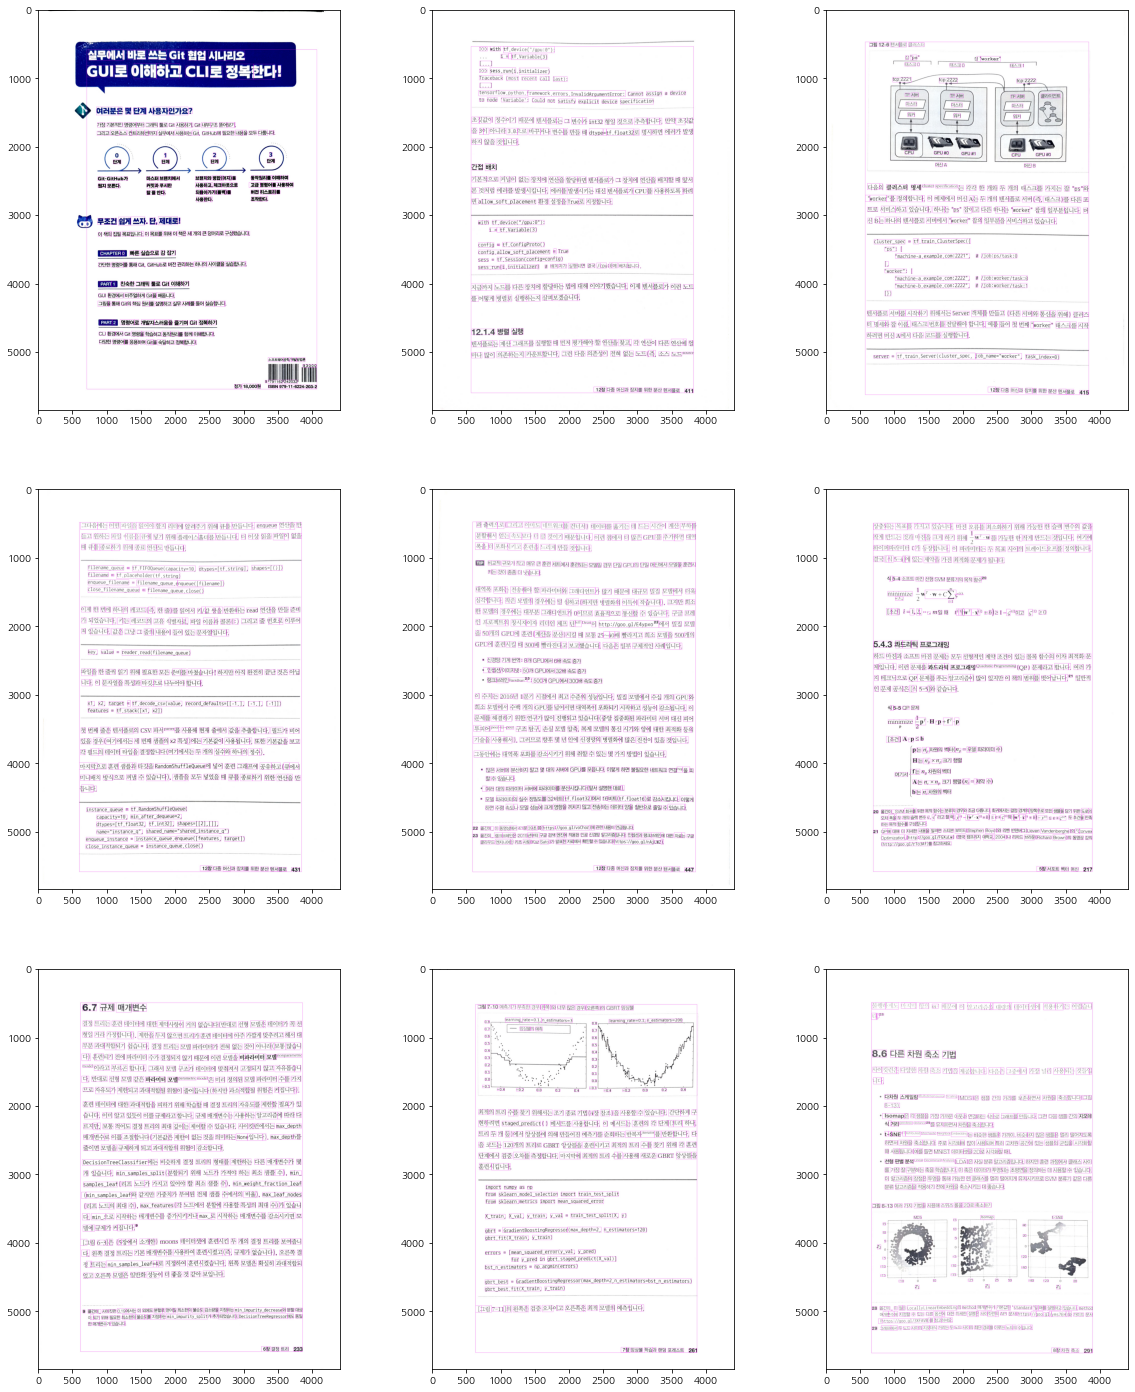

In [57]:
input_img_ls =glob.glob('/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_*.jpg')
input_img_ls = sorted(input_img_ls)

output_img_path = '/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for input_img in input_img_ls:
    detect_text_with_google(input_img, output_img_path)

output_img_ls = glob.glob('/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/google/page_*.jpg')
output_img_ls = sorted(output_img_ls)

plt.figure(figsize=(20, 25))

for idx, image in enumerate(output_img_ls):
    plt.subplot(3, 3, idx+1)
    plt.axis('off')
    img = plt.imread(image)
    plt.imshow(img)
    

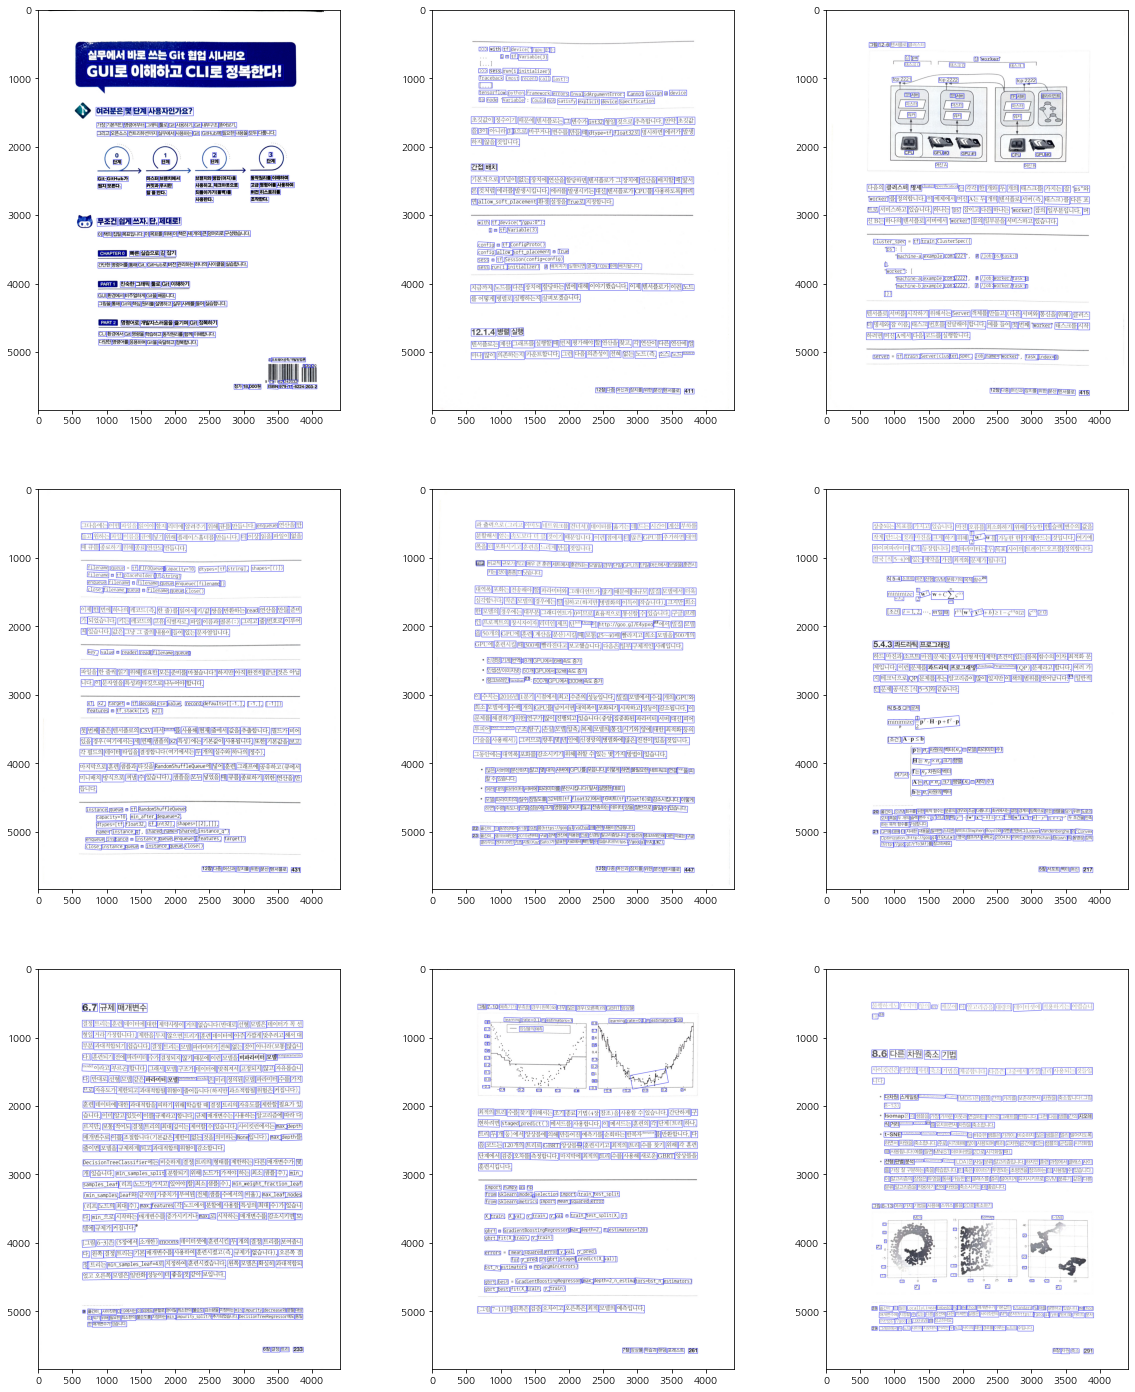

In [87]:
input_img_ls =glob.glob('/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_*.jpg')
input_img_ls = sorted(input_img_ls)

output_img_path = '/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/'

for input_img in input_img_ls:
    detect_text_with_keras(input_img, output_img_path)

output_img_ls = glob.glob('/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/keras/page_*.jpg')
output_img_ls = sorted(output_img_ls)

plt.figure(figsize=(20, 25))

for idx, image in enumerate(output_img_ls):
    plt.subplot(3, 3, idx+1)
    plt.axis('off')
    img = plt.imread(image)
    plt.imshow(img)

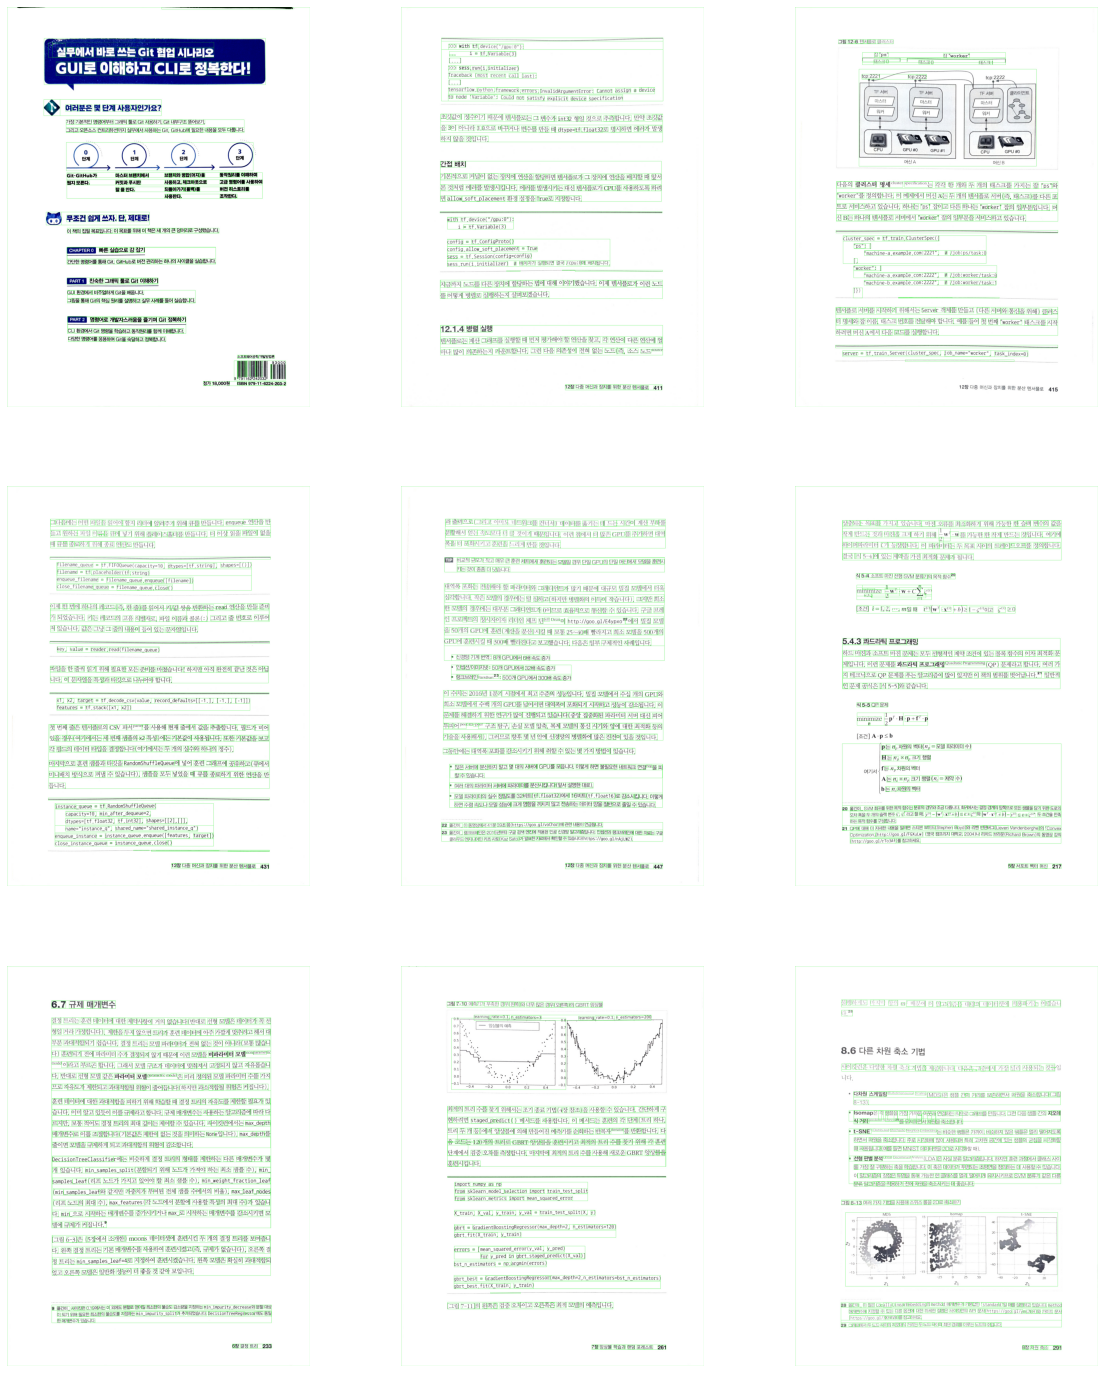

In [97]:
input_img_ls =glob.glob('/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_*.jpg')
input_img_ls = sorted(input_img_ls)

output_img_path = '/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/'

for input_img in input_img_ls:
    detect_text_with_tesseract(input_img, output_img_path)

output_img_ls = glob.glob('/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/tesseract/page_*.jpg')
output_img_ls = sorted(output_img_ls)

plt.figure(figsize=(20, 25))

for idx, image in enumerate(output_img_ls):
    plt.subplot(3, 3, idx+1)
    plt.axis('off')
    img = plt.imread(image)
    plt.imshow(img)

**Detection의 경우에는 세가지 OCR보두 준수한 성능을 보여주고 있으며 모델에 따라 bounding box의 모양이 조금씩 차이가 나고 이를 통해 detection을 하는 단위가 모델에 따라 다름을 알 수 있다**

##### 3-2 recognization

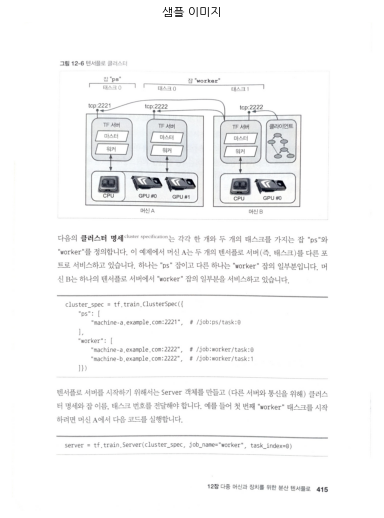

In [96]:
image_path = '/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_3.jpg'
img = plt.imread(image_path)

plt.figure(figsize=(7, 9))
plt.axis('off')
plt.title('샘플 이미지')
plt.imshow(img)

- GOOGLE_OCR

In [82]:
image_path = '/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_3.jpg'
output_img_path = '/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/'
texts = detect_text_with_google(image_path, output_img_path)

for text in texts:
    print('\n"{}"'.format(text.description))


"그림 12-6 텐서플로 클러스터
잡 "ps"
Y "worker"
태스크 0
태스크 0
태스크 1
tcp:2221
tcp:2222
tcp:2222
TF 서버
TF 서버
TF 서버
클라이언트
마스터
마스터
마스터
워커
워커
워커
CPU
GPU #0
GPU #1
CPU
GPU #0
머신 A
머신 B
다음의 클러스터 명세 cluster specification는 각각 한 개와 두 개의 태스크를 가지는 잡 "ps"와
"worker"를 정의합니다. 이 예제에서 머신 A는 두 개의 텐서플로 서버(즉, 태스크)를 다른 포
트로 서비스하고 있습니다. 하나는 "ps" 잡이고 다른 하나는 "worker" 잡의 일부분입니다. 머
신 B는 하나의 텐서플로 서버에서 "worker" 잡의 일부분을 서비스하고 있습니다.
cluster_spec = tf train.ClusterSpec({
"ps": [
"machine-a.example.com:2221", # /job:ps/task:0
%3D
],
"worker": [
"machine-a.example.com:2222", # /job:worker/task:0
"machine-b.example.com:2222", # /job:worker/task:1
]})
텐서플로 서버를 시작하기 위해서는 Server 객체를 만들고 (다른 서버와 통신을 위해) 클러스
터 명세와 잡 이름, 태스크 번호를 전달해야 합니다. 예를 들어 첫 번째 "worker" 태스크를 시작
하려면 머신 A에서 다음 코드를 실행합니다.
server =
tf.train.Server(cluster_spec, job_name="worker", task_index=0)
12장 다중 머신과 장치를 위한 분산 텐서플로 415
"

"그림"

"12-6"

"텐서"

"플로"

"클러스터"

"잡"

"""

"ps"

"""

"Y"

""worker""

"태스크"

"0"

"태스크"

"0"

"태스크"

"1"

"tcp:2221"

"tcp:2222"

"tcp:2222"

"T

**문자 인식률이 높아 대부분의 문장을 확인할 수 있다**

- KERAS OCR

In [83]:
image_path = '/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_3.jpg'
output_img_path = '/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/'
texts = detect_text_with_keras(image_path, output_img_path)

for text in texts:
    print(text[0])

exee
exee
da
126
see
y
ps
le
worker
ehbo
ehaeo
eei
tcp2221
tcp2222
tcp2222
tf
ie
ejoigee
tf
xu
ajel
tf
dae
dse
ose
of
of
of
cpu
gpu
ho
gpufl
gpu
ho
cpu
osia
oaib
cluster
specification
too
sle
slil
d
zz
sh
71s7
t
7hol
eee
zezll
z
psst
foslt
e
alllo
worker
ol
dh
alt
7h0
elee
pae
esae
tey
hakot
wele
ofliy
zholn
te
flil
ee
zlo
oolet
ps
worker
da
slo
elee
aeoll
zlo
orre
be
worker
sepo
ualt
clusterspecr
tf
train
clusterspec
ps
2221
ijobb
machinera
example
f
psl
taskio
comi
i
workert
2222
ijobi
examples
f
workerl
machinera
comi
taski
o
ijobi
machinerbe
examples
2222
f
workerl
coms
taski
t
is
olope
taile
eles
aee
azo7
server
dez
ee
ses
6lle
olod
eas
seollo
plies
dis
oe
leeo
e
zoe
ese
b
ia
esee
worker
az
to
saee
assle
sfee
aole
che
tf
serverclus
ter
job
train
spece
names
worker
task
indexe
server
o0
125
crs
csn
sae
e
sss
eses
415


**한글이 학습이 되어 있지 않아 엉뚱하게 인식하는 것을 볼 수 있다. Keras ocr을 한글에 활용하기위해서는 한글 데이터를 통해 학습이 필요할 것 같다.**

- TESSERACT_OCR

In [84]:
image_path = '/home/aiffel/Aiffel/17_OCR_python/input_images/ocr_test/page_3.jpg'
output_img_path = '/home/aiffel/Aiffel/17_OCR_python/output_images/ocr_test/'
texts = detect_text_with_tesseract(image_path, output_img_path)

print(texts['text'])

그림 12-6 텐서플로 클러스터

잡 "29"                                "worker"
—aaa07 7 >See 22022
태스크 0            태스크 0                 태스크 1

tcp:2221                tcp:2222

 

CHES] RAE] Aver veciteaions ae} Se A} F HO] ASS 7p 잡 "85"와
‘worker"S Mle tf, 이 예제에서 머신 ㅅ는 두 개의 텐서플로 서버(즉, 태스크)를 다른 포
트로 서비스하고 있습니다. 하나는 "66" 잡이고 다른 하나는 "00ㅠ<@+" 잡의 일부분입니다. 머
신 8는 하나의 텐서플로 서버에서 "00ㅁ<6ㅠ" 잡의 일부분을 서비스하고 있습니다.

 

cluster_spec = tf,train, ClusterSpec({
"os":  [
“machine-a.example,com:2221", # /job:ps/task:0
l,

“worker": [
“machine-a.example,com:2222", # /job:worker/task:0

"machine-b.example,com:2222", # /job:worker/task:1

16

—— 녀나나나나 02020

텐서플로 서버를 시작하기 위해서는 56706 객체를 만들고 (다른 서버와 통신을 위해) 클러스
터 명세와 잡 이름, 태스크 번호를 전달해야 합니다. 예를 들어 첫 번째 “worker” PASS 2/2}
하려면 머신 에서 다음 코드를 실행합니다.

 

server = tf.train.Server(cluster_spec, job_name="worker" task_index=0)

 



**한글로 인식이 되었지만 중간 중간 잘못된 부분을 확인할 수 있다**

#### 4. 결론 

- detection의 성능은 큰 차이가 없었지만 recognization에서 큰 차이가 났다. Google OCR이 가장 정확하게 인식하는 것을 볼 수 있었고 이를 활용하여 PDF 파일을 OCR을 수행하는 것이 좋은 성능을 기대할 수 있을것이라고 생각한다. 
- keras ocr의 경우에는 한글 자체가 학습이 되어 있지 않아 비교 대상으로 삼기에는 어려움이 있었고 데이터 확보가 가능하다면 한글을 학습시켜 비교해보는 것이 적합할 것이라 생각한다. 

#### 5. 고찰
- OCR의 성능이 많이 발전되었지만 스캔한 이미지의 글씨의 선명도가 일정하지 않거나 노이즈등 이미지의 상태에 따라 인식이 정상적으로 안되는 경우를 많이 볼 수 있었다.
- OCR을 수행하기 전 글자의 선명도를 올리는 기능이 추가된다면 OCR의 더 좋은 성능을 기대할 수 있을 것이라고 예상한다.